In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore

import nibabel as nib
from nilearn.glm.first_level import glover_hrf
from nilearn.plotting import plot_anat, plot_epi, plot_glass_brain, plot_roi
from nilearn.image import mean_img, resample_img

main_path = "/jukebox/PNI-classes/students/NEU502/2023-NEU502B/wlong/multilang/"

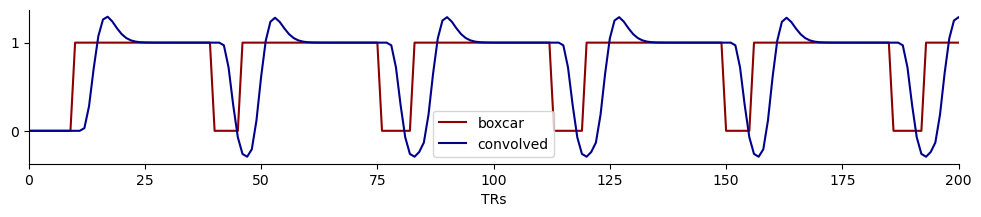

In [2]:
# load stimulus data
stim_df = pd.read_csv(os.path.join(main_path, 'stimulus_record/780929_502b_project_code_edited_2023-04-05_13h44.30.136.csv'))
t_scan_start = stim_df['key_resp.started'][0] + stim_df['key_resp.rt'][0]
stim_df.Language = stim_df.Language.str.split('_', expand=True).to_numpy()
stim_df.stimFile = stim_df.stimFile.str.split('/|_', expand=True).to_numpy()
stim_df.StimFile = stim_df.StimFile.str.split('/|_', expand=True).to_numpy()
stim_df['word'] = stim_df.stimFile

stim_df.loc[stim_df.word.isnull(), 'word'] = stim_df.loc[stim_df.word.isnull(), 'StimFile']
stim_df = stim_df[~stim_df.word.isnull()].reset_index(drop=True)

tr = 1.5
n_trs = 630
time = np.arange(0, n_trs*tr, tr)
stim_trs, _ = np.histogram(stim_df['Sound.started']-t_scan_start, bins=time)  # stims binned into TRs (have not adjusted for if they are presented right at the end of a TR)


## Detecting start and end time
stim_start = stim_df['Sound.started'].to_numpy() - t_scan_start
block_start_indices = np.where(np.diff(stim_start) > 5.5)[0]
## Total switches: (3 session * 6 languages) - 1 = 17
assert len(block_start_indices) == 17 

block_end_time = stim_start[block_start_indices]
iti_interval = stim_start[block_start_indices + 1] - stim_start[block_start_indices]
block_start_time = (block_end_time + iti_interval)[:-1]
## Insert first stim start at the beginning
block_start_time = np.insert(block_start_time, 0, stim_start[0])
duration = block_end_time - block_start_time

hrf = glover_hrf(tr, time_length = 45, oversampling = 1)

fig, ax = plt.subplots(figsize=(12, 2), sharex = True, sharey = True)

stim_arr = np.zeros(n_trs)
for start, end in zip(block_start_time, block_end_time):
    stim_arr[int(start / tr): int(end / tr)] = 1

stim_conv = np.convolve(stim_arr, hrf)[:n_trs]

ax.plot(stim_arr, c = "darkred", label = "boxcar")
ax.plot(stim_conv, c = "darkblue", label = "convolved")
ax.set_yticks([0, 1])
ax.set_xlim(0, 200)
ax.set_xlabel("TRs")
ax.legend()
sns.despine()

In [3]:
data_path = os.path.join(main_path, "data/bids/")
confounds_f = os.path.join(data_path, 'derivatives/fmriprep/sub-002/ses-01/func/sub-002_ses-01_task-language_desc-confounds_timeseries.tsv')
confounds_df = pd.read_table(confounds_f, sep='\t')

## Head motion confounds
hm_labels = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']
hm = confounds_df[hm_labels].values

## aCompCor
acompcor_n = 5
acompcor_df = confounds_df.filter(regex='a_comp_cor').iloc[:, :acompcor_n]
acompcor_labels = acompcor_df.columns.tolist()
acompcor = acompcor_df.values
acompcor = acompcor[: n_trs,:]

## FD 
fd_threshold = 0.25

# Extract framewise displacement
fd = confounds_df['framewise_displacement'].values

# Identify bad volumes
bad_vols = np.argwhere(fd > fd_threshold).ravel()
n_bad = bad_vols.shape[0]
print(f'{n_bad} bad volumes')

# Construct scrubbers
censors = np.zeros((fd.shape[0], n_bad))
censors[bad_vols, np.arange(n_bad)] = 1
censor_labels = [f'censor{c}' for c in np.arange(censors.shape[1])]

confounds = np.column_stack([np.ones(n_trs), hm, censors, acompcor])
confound_labels = ['intercept'] + hm_labels + censor_labels + acompcor_labels

5 bad volumes


In [4]:
func_path = os.path.join(data_path, 'sub-002/ses-01/func/sub-002_ses-01_task-language_bold.nii.gz')
anat_path = os.path.join(data_path, 'sub-002/ses-01/anat/sub-002_ses-01_T1w.nii.gz')

func_nib = nib.load(func_path)
func_data = func_nib.get_fdata()
anat_img = nib.load(anat_path).get_fdata().astype(bool)

(91, 109, 91)


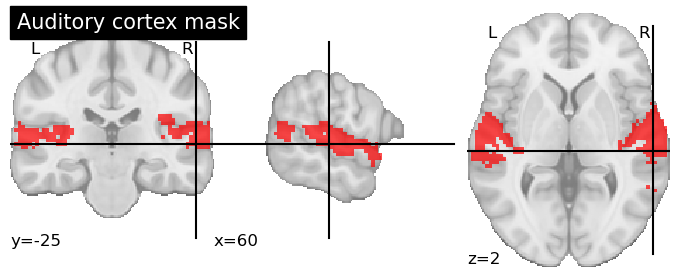

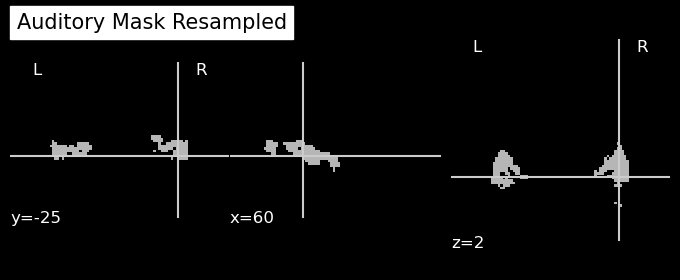

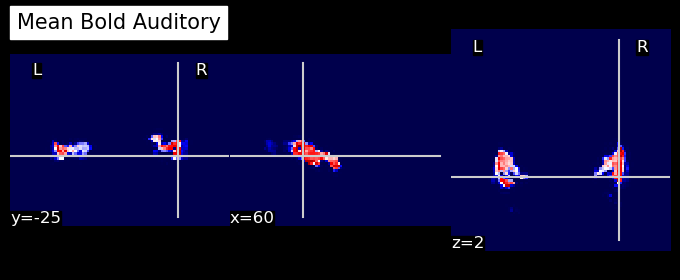

In [5]:
# get auditory mask
# source of auditory mask: https://github.com/ThomasYeoLab/CBIG/tree/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI
# left hemisphere aud is 137-146 inclusive. right hem is 336-344. if you change the parcel file, you will need to go the the 
aud = np.hstack((np.arange(137, 147), np.arange(336, 345)))
masker_path = 'Schaefer2018_400Parcels_Kong2022_17Networks_order_FSLMNI152_2mm.nii.gz'
cut_coords = (60, -25, 2)
aud_masker = nib.load(os.path.join(main_path, "masks", masker_path))
aud_masker_data = aud_masker.get_fdata()
print(aud_masker_data.shape)
aud_masker_data = np.where(np.isin(aud_masker_data, aud), 1., 0)
aud_masker_img = nib.Nifti1Image(aud_masker_data, affine=aud_masker.affine)

# resample mask to match functional data
func_img = nib.load(func_path)
masker = resample_img(aud_masker_img, func_img.affine, target_shape=func_data.shape[:3], interpolation='nearest')

plot_roi(masker, cut_coords=cut_coords, cmap='bwr_r', 
         title='Auditory cortex mask')
mask_aud = func_data.transpose(3, 0, 1, 2) * masker.get_fdata()  #using the apply mask function wasn't working at first
mask_aud = nib.Nifti1Image(mask_aud.transpose(1, 2, 3, 0), affine=func_img.affine)

plot_anat(masker, cut_coords=cut_coords, title='Auditory Mask Resampled');
plot_epi(mean_img(mask_aud), cut_coords=cut_coords, cmap='seismic', title='Mean Bold Auditory');

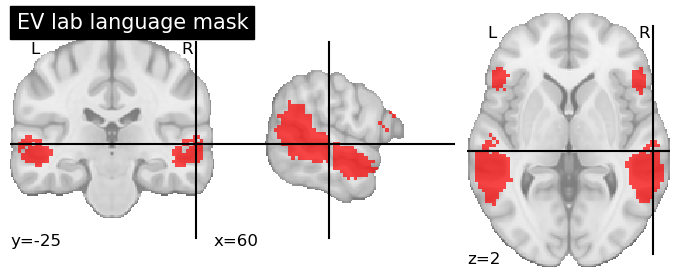

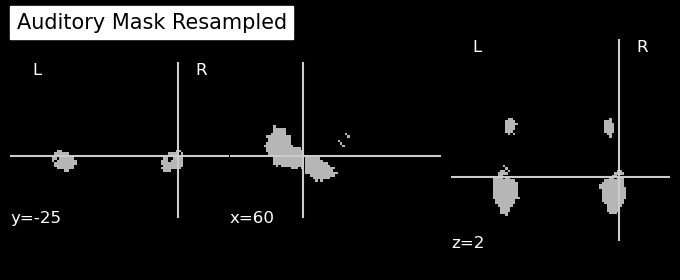

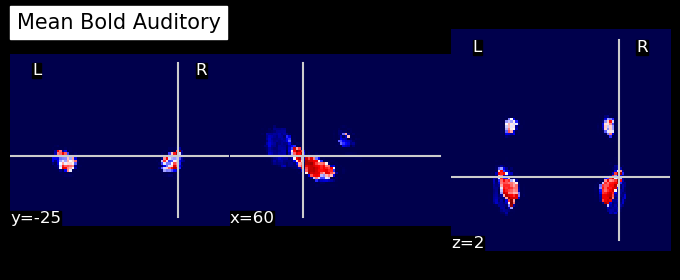

In [6]:
## Mask recommended by Sam - Language parcels
## https://evlab.mit.edu/funcloc/

masker_path = 'allParcels_language_SN220.nii.gz'
cut_coords = (60, -25, 2)
lang_evlab_mask = nib.load(os.path.join(main_path, "masks", masker_path))
lang_evlab_data = lang_evlab_mask.get_fdata()

lang_bool_mask = nib.Nifti1Image(np.where(lang_evlab_data >= 1, 1., 0), 
                                 affine=lang_evlab_mask.affine)

masker = resample_img(lang_bool_mask, func_img.affine, 
                      target_shape=func_data.shape[:3], 
                      interpolation='nearest')

mask_aud = func_data.transpose(3, 0, 1, 2) * masker.get_fdata()  #using the apply mask function wasn't working at first
mask_aud = nib.Nifti1Image(mask_aud.transpose(1, 2, 3, 0), affine=func_img.affine)

plot_roi(masker, cut_coords=cut_coords, cmap='bwr_r', 
         title='EV lab language mask');
plot_anat(masker, cut_coords=cut_coords, title='Auditory Mask Resampled');
plot_epi(mean_img(mask_aud), cut_coords=cut_coords, cmap='seismic', title='Mean Bold Auditory');

In [7]:
# get n_times x n_voxels array of fmri signal within auditory cortex over time
bold_masked = func_data[masker.get_fdata().astype(bool)].T
print('masked data shape:', bold_masked.shape)

Y = zscore(bold_masked[:n_trs], axis=0)

# Assemble all regressors
X = np.column_stack([stim_conv, confounds])
# Assemble all regressor labels
regressor_labels = ['blocks'] + confound_labels

masked data shape: (630, 6940)


beta shape: (18, 6940)


/usr/people/tt1131/.conda/envs/neu502b/lib/python3.10/site-packages/nilearn/_utils/niimg.py:63: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


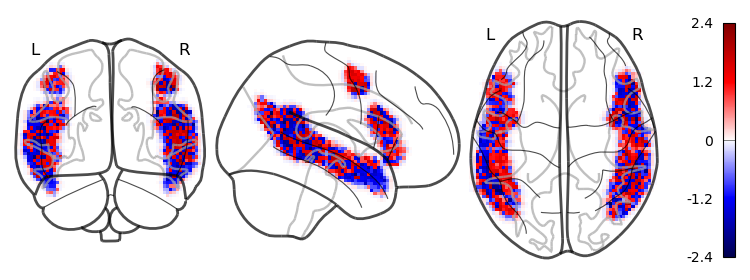

In [8]:
# Run regression with basic OLS
b, _, _, _ = np.linalg.lstsq(X, Y, rcond=-1)
print('beta shape:', b.shape)

# Make beta coefficient brain map
beta_map = np.zeros(masker.shape)
mask_coords = np.where(masker.get_fdata() == 1)
beta_map[mask_coords] = b[1]

# Convert zero values to NaNs for plotting
beta_map[beta_map == 0] = np.nan

beta_img = nib.Nifti1Image(beta_map, affine=masker.affine)

plot_glass_brain(beta_img, colorbar=True, cmap='seismic', threshold=0.02, 
                 plot_abs=False)

<AxesSubplot: >

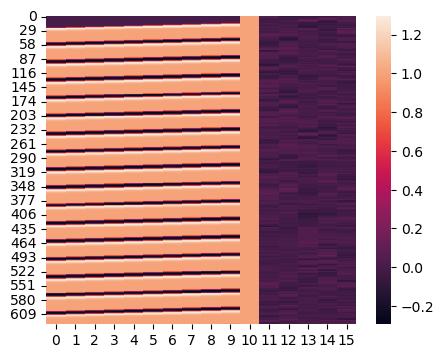

In [9]:
# time lagged regression
from scipy.linalg import hankel

filt_len = 10
padded_stim = np.pad(stim_conv, (filt_len-1, 0), constant_values=(0, 0))
X = hankel(padded_stim[:-filt_len+1], 
           padded_stim[-filt_len:])
X = np.hstack((X, np.ones((X.shape[0], 1))))
X = np.hstack((X, acompcor))
fig, axs = plt.subplots(1, 1, figsize=(5, 4))
sns.heatmap(X, ax=axs)

beta shape: (16, 6940)


/usr/people/tt1131/.conda/envs/neu502b/lib/python3.10/site-packages/nilearn/_utils/niimg.py:63: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


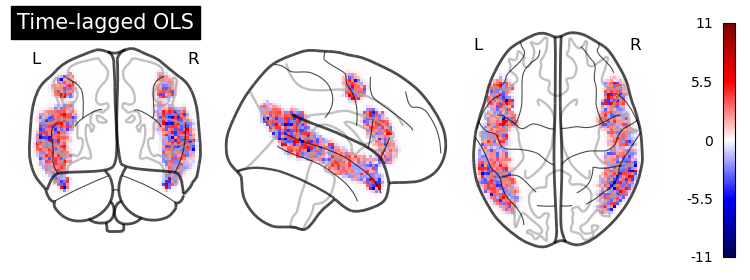

In [10]:
# Run regression with basic OLS
b, _, _, _ = np.linalg.lstsq(X, Y, rcond=-1)
print('beta shape:', b.shape)

# Make beta coefficient brain map
beta_map = np.zeros(masker.shape)
mask_coords = np.where(masker.get_fdata() >= 1)
beta_map[mask_coords] = b[1]

# Convert zero values to NaNs for plotting
beta_map[beta_map == 0] = np.nan

beta_img = nib.Nifti1Image(beta_map, affine=masker.affine)

plot_glass_brain(beta_img, colorbar=True, cmap='seismic', 
                 plot_abs=False, title='Time-lagged OLS');

### Tring with nilearn FirstLevelModel

In [11]:
from pandas import DataFrame
from nilearn.glm.first_level import FirstLevelModel

checkerboard_df = DataFrame({"onset": block_start_time, 
                             "duration": duration})
checkerboard_df["event"] = "Checkerboard"

confounds_df = DataFrame({l: c for l, c in zip(confound_labels, confounds.T)
                          if l != 'intercept'})

# Intialize Nilearn's GLM
glm = FirstLevelModel(t_r=tr,
                      mask_img=masker,
                      noise_model='ar1',
                      standardize=True,
                      hrf_model='glover',
                      drift_model='cosine',
                      high_pass=1/128)

# Fit the GLM to BOLD data
glm.fit(func_nib, 
        events=checkerboard_df, 
        confounds=confounds_df)

/usr/people/tt1131/.conda/envs/neu502b/lib/python3.10/site-packages/nilearn/glm/first_level/experimental_paradigm.py:74: UserWarning: 'trial_type' column not found in the given events data.
  warnings.warn("'trial_type' column not found "
/usr/people/tt1131/.conda/envs/neu502b/lib/python3.10/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `event` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "


FirstLevelModel(high_pass=0.0078125,
                mask_img=<nibabel.nifti1.Nifti1Image object at 0x7f49ad22bf10>,
                t_r=1.5)

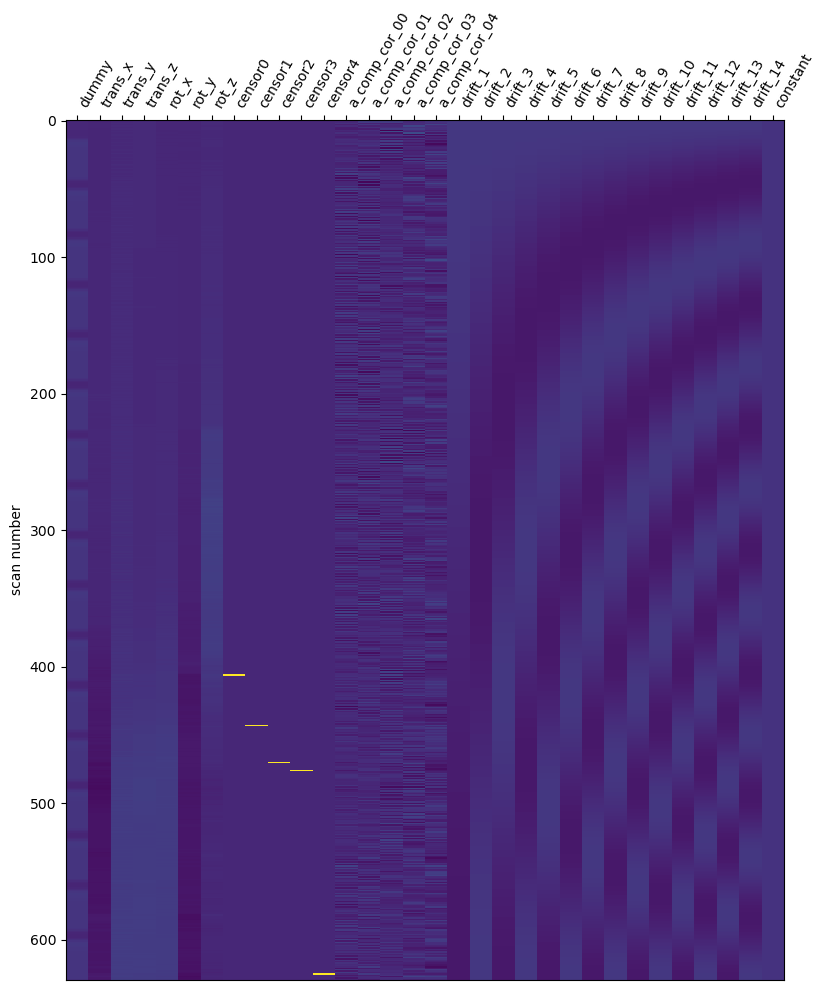

In [12]:
# Extract Nilearn's design matrix and plot it
from nilearn.plotting import plot_design_matrix

design_matrix = glm.design_matrices_[0]
plot_design_matrix(design_matrix)
plt.show()

In [13]:
contrast = np.zeros(len(glm.design_matrices_[0].columns))
contrast[0] = 1

# Extract betas for contrast
beta_map = glm.compute_contrast(contrast,
               output_type='effect_size').get_fdata()
beta_map[beta_map == 0] = np.nan

/usr/people/tt1131/.conda/envs/neu502b/lib/python3.10/site-packages/nilearn/_utils/niimg.py:63: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


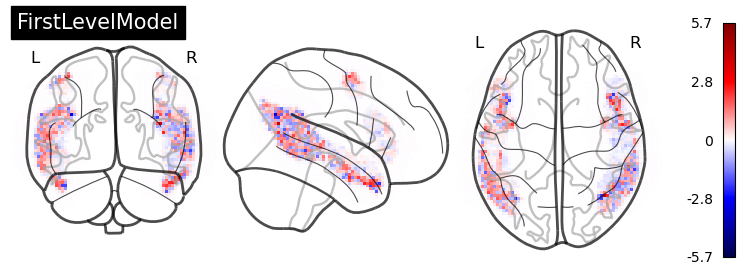

In [14]:
beta_img = nib.Nifti1Image(beta_map, affine=masker.affine)

plot_glass_brain(beta_img, colorbar=True, cmap='seismic', 
                 plot_abs=False, title='FirstLevelModel');